-사전학습(Pre-training)과 미세조정(Fine-tuning) 분리
-모델 구조 및 하이퍼파라미터
-12-layer, 768-dim, 12-head Transformer Decoder 구조를 사용
-보조 언어모델링 목적(Auxiliary LM Objective) 활용
-미세조정(Fine-tuning): 챗봇 데이터로 입력을 변환하여 미세조정
-미세조정 시 loss = supervised_loss + λ * language_model_loss 활용
-캐주얼 마스크 사용
-임베딩 + 포지셔널 인코딩 → 디코더 블록 스택 → 출력 레이어


In [2]:
import math
import os
import re
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("슝=3")

슝=3


In [3]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]  # 입력의 시퀀스 길이
        # 포지셔널 인코딩 동적 생성
        pos_encoding = self.positional_encoding(seq_len, self.d_model)
        return inputs + pos_encoding[:, :seq_len, :]

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model
        )
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        return pos_encoding[tf.newaxis, ...]

    def get_angles(self, position, i, d_model):
        base = tf.cast(10000, tf.float32)
        exponent = (2 * (i // 2)) / tf.cast(d_model, tf.float32)
        return position / tf.pow(base, exponent)


print("슝=3")

슝=3


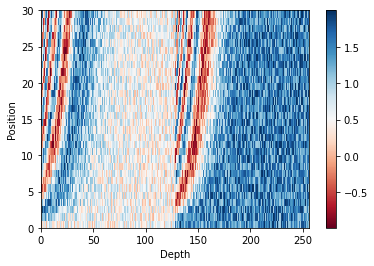

In [13]:
dummy_input = tf.random.uniform(shape=(1, 30, 256))  # (batch, seq_len, d_model)

# 포지셔널 인코딩 계산
pos_encoding = sample_pos_encoding(dummy_input).numpy()

# 시각화
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

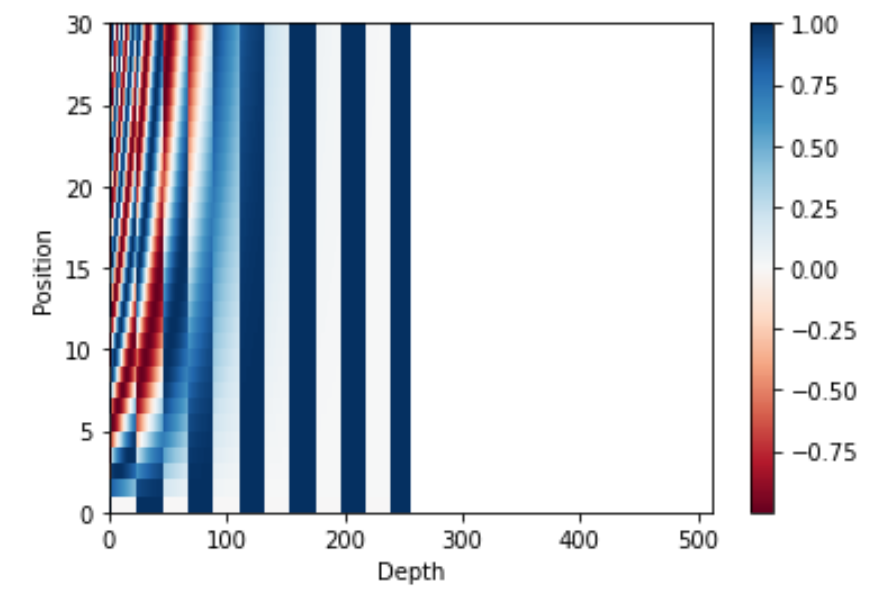

In [14]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


In [15]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


패딩마스크와 룩어헤드 마스크 삭제

기존 인코더,디코더,인코더 레이어,디코더 레이어 삭제

마스크 함수 재정의

In [16]:
# 캐주얼 마스크 생성 함수 추가
def create_causal_mask(seq_len):
    return 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

디코더레이어 재정의

In [17]:
class decoder_layer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(d_model*4, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(axis=-1)
        self.layernorm2 = tf.keras.layers.LayerNormalization(axis=-1)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        # 입력 형태 강제 (batch, seq_len, d_model)
        x = tf.ensure_shape(x, [None, None, self.d_model])
        
        # 셀프 어텐션
        attn_output = self.mha({'query': x, 'key': x, 'value': x, 'mask': mask})
        attn_output = tf.ensure_shape(attn_output, [None, None, self.d_model])
        
        # 잔차 연결 & 레이어 정규화
        out1 = self.layernorm1(x + self.dropout(attn_output))
        out1 = tf.ensure_shape(out1, [None, None, self.d_model])
        
        # FFN
        ffn_output = self.ffn(out1)
        ffn_output = tf.ensure_shape(ffn_output, [None, None, self.d_model])
        
        # 최종 출력
        return self.layernorm2(out1 + self.dropout(ffn_output))


gpt-1 스타일 디코더 생성

In [18]:
# GPT-1 스타일 디코더
class GPTDecoder(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads):
        super().__init__()
        self.dec_layers = [TransformerDecoderLayer(d_model, num_heads) 
                          for _ in range(num_layers)]
        
    def call(self, inputs, mask=None):
        for layer in self.dec_layers:
            inputs = layer(inputs, mask)
        return inputs

In [19]:
data_dir = os.path.expanduser('/aiffel/aiffel/transformer_chatbot/data/')
chatbot_data_path = os.path.join(data_dir, 'ChatbotData.csv')
print("슝=3")

슝=3


In [20]:
#!wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv -O ~/aiffel/transformer_chatbot/data/ChatbotData.csv

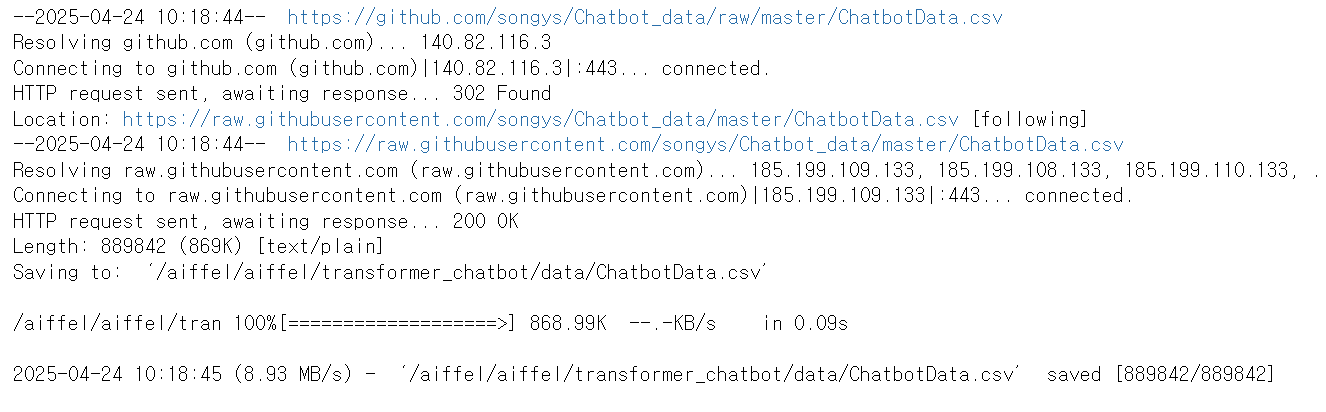
파일 연결이 잘 작동되지 않아 파일을 재다운로드후 진행

In [21]:
print(os.path.getsize('/aiffel/aiffel/transformer_chatbot/data/ChatbotData.csv'))


889842


확인
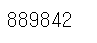

In [22]:
print(data_dir)

/aiffel/aiffel/transformer_chatbot/data/


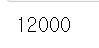

In [23]:
#사전학습 텍스트 데이터
#코퍼스 다운로드
corpus = []
with open("/aiffel/aiffel/transformer_chatbot/data/kosentences/data/kowiki.txt", encoding="utf-8") as f:
    for i, line in enumerate(f):
        line = line.strip()
        if line:
            corpus.append(line)
        if i >= 19999:  # 2만 문장만 예시로 사용
            break

#토크나이저 학습
import tensorflow_datasets as tfds
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    corpus, target_vocab_size=2**13
)
VOCAB_SIZE = tokenizer.vocab_size + 2

In [24]:
# 예시 문장 하나 출력
print("코퍼스에서 첫 번째 문장:", corpus[0])

# 토크나이저 인코딩/디코딩 테스트
encoded = tokenizer.encode(corpus[0])
print("토크나이저 인코딩 결과:", encoded)

decoded = tokenizer.decode(encoded)
print("토크나이저 디코딩 결과:", decoded)


코퍼스에서 첫 번째 문장: 세계수의 미궁 시리즈에 전통으로 등장하는 대사.
토크나이저 인코딩 결과: [793, 1630, 66, 3832, 5291, 4709, 13, 1079, 858, 8008]
토크나이저 디코딩 결과: 세계수의 미궁 시리즈에 전통으로 등장하는 대사.


사전학습 데이터 전처리

In [25]:
def preprocess_line(line):  # 매개변수명 line으로 정의
    # 양쪽 공백 제거
    line = line.strip()  
    
    # 한글이 포함되어 있는지 확인
    if re.search(r'[\uac00-\ud7a3]', line):
        # 한글 처리: 한글, 영어, 구두점만 남기고 나머지는 공백으로 대체
        line = line.lower()
        # 구두점 분리
        line = re.sub(r"([?.!,])", r" \1 ", line)
        line = re.sub(r'[" "]+', " ", line)
        # 한글, 영어, 구두점만 남기고 모두 공백으로
        line = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", line)
        line = line.strip()
        return line
    else:
        # 영어 처리 (기존과 동일)
        line = line.lower()
        line = re.sub(r"([?.!,])", r" \1 ", line)
        line = re.sub(r'[" "]+', " ", line)
        line = re.sub(r"[^a-zA-Z?.!,]+", " ", line)
        line = line.strip()
        return line


print("슝=3")
print(preprocess_line("나는 학교에 갔습니다!"))
# 출력: 나는 학교에 갔습니다 !

print(preprocess_line("I am a student."))
# 출력: i am a student .


슝=3
나는 학교에 갔습니다 !
i am a student .


In [26]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [27]:
def preprocess_sentence(sentence):
    # 양쪽 공백 제거
    sentence = sentence.strip()
    
    # 한글이 포함되어 있는지 확인
    if re.search(r'[\uac00-\ud7a3]', sentence):
        # 한글 처리: 한글, 영어, 구두점만 남기고 나머지는 공백으로 대체
        sentence = sentence.lower()
        # 구두점 분리
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        # 한글, 영어, 구두점만 남기고 모두 공백으로
        sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence)
        sentence = sentence.strip()
        return sentence
    else:
        # 영어 처리 (기존과 동일)
        sentence = sentence.lower()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
        sentence = sentence.strip()
        return sentence

print("슝=3")
print(preprocess_sentence("나는 학교에 갔습니다!"))
# 출력: 나는 학교에 갔습니다 !

print(preprocess_sentence("I am a student."))
# 출력: i am a student .


슝=3
나는 학교에 갔습니다 !
i am a student .


전처리 확인
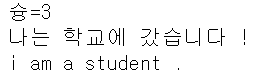

In [28]:
def load_conversations():
    chatbot_data = pd.read_csv(chatbot_data_path)
    inputs = []
    outputs = []
    
    # Q를 입력, A를 출력으로 매핑
    for q, a in zip(chatbot_data['Q'], chatbot_data['A']):
        inputs.append(preprocess_sentence(q))
        outputs.append(preprocess_sentence(a))
        
        # 최대 샘플 수 제한 (옵션)
        if len(inputs) >= MAX_SAMPLES:
            break
    
    return inputs, outputs

def build_contextual_pairs(questions, answers, context_size=2):
    new_inputs, new_outputs = [], []
    for i in range(context_size, len(questions)):
        context = []
        for j in range(context_size):
            context.append(f"Q: {questions[i-j-1]} $ A: {answers[i-j-1]}")
        new_inputs.append(" $ ".join(context) + " $ Q: " + questions[i])
        new_outputs.append(answers[i])
    return new_inputs, new_outputs

print("슝=3")


슝=3


In [29]:
# 데이터 로드
questions, answers = load_conversations()

# 맥락 포함 쌍 생성 (context_size=2 예시)
questions, answers = build_contextual_pairs(questions, answers, context_size=2)
# 결과 확인
print("질문 예시:", questions[:3])
print("답변 예시:", answers[:3])

질문 예시: ['Q: 지망 학교 떨어졌어 $ A: 위로해 드립니다 . $ Q: 시 땡 ! $ A: 하루가 또 가네요 . $ Q: 박 일 놀러가고 싶다', 'Q: 박 일 놀러가고 싶다 $ A: 여행은 언제나 좋죠 . $ Q: 지망 학교 떨어졌어 $ A: 위로해 드립니다 . $ Q: 박 일 정도 놀러가고 싶다', 'Q: 박 일 정도 놀러가고 싶다 $ A: 여행은 언제나 좋죠 . $ Q: 박 일 놀러가고 싶다 $ A: 여행은 언제나 좋죠 . $ Q: ppl 심하네']
답변 예시: ['여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


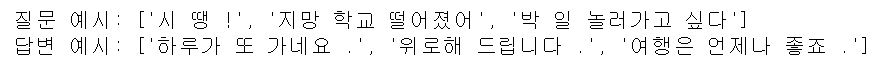

In [30]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[22]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[22]))

전처리 후의 22번째 질문 샘플: Q: 가족 여행 가기로 했어 $ A: 온 가족이 모두 마음에 드는 곳으로 가보세요 . $ Q: 가장 확실한 건 뭘까 ? $ A: 가장 확실한 시간은 오늘이에요 . 어제와 내일을 놓고 고민하느라 시간을 낭비하지 마세요 . $ Q: 가족 여행 고고
전처리 후의 22번째 답변 샘플: 온 가족이 모두 마음에 드는 곳으로 가보세요 .


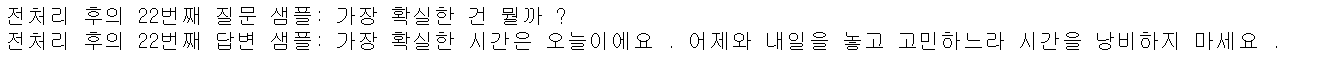

In [31]:
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [32]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [33]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8142]
END_TOKEN의 번호 : [8143]


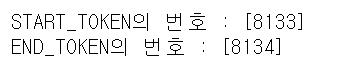

In [34]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8144


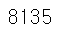

In [35]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [7967, 1, 393, 814, 44, 418, 5, 7951, 1, 393, 814, 916, 6517, 15, 5070, 7577, 1115, 7762, 354, 5582, 47, 2, 7967, 1, 5747, 615, 2488, 4152, 3, 7951, 1, 2358, 7488, 11, 6255, 101, 2, 7967, 1, 5739, 434, 7871, 148]
정수 인코딩 후의 21번째 답변 샘플: [1090, 3170, 596, 269, 882, 626, 293, 4]


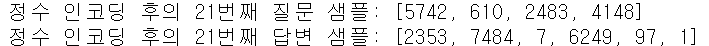

In [36]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 512
print(MAX_LENGTH)

512


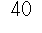

In [37]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [38]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8144
필터링 후의 질문 샘플 개수: 11821
필터링 후의 답변 샘플 개수: 11821


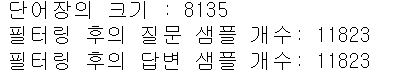

인코더-디코더 입력을 단일 시퀸스 입력으로 변경

In [39]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000
def format_input(context):
    return f"[CONTEXT]{context}[/CONTEXT]"

formatted_inputs = [format_input(ctx) for ctx in questions]
dataset = tf.data.Dataset.from_tensor_slices(
    (formatted_inputs, answers))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


데이터셋 생성 함수 추가

In [65]:
def create_lm_dataset(tokenizer, file_path, seq_length=128, batch_size=8):
    def encode(text):
        text_str = text.numpy().decode('utf-8')
        tokens = tokenizer.encode(text_str)
        tokens = [tokenizer.vocab_size] + tokens + [tokenizer.vocab_size + 1]
        
        # 패딩 추가 (최소 길이 보장)
        if len(tokens) < seq_length + 1:
            tokens += [0] * (seq_length + 1 - len(tokens))
        return tokens[:seq_length + 1]

    # 1. 데이터셋 로드 및 필터링
    dataset = tf.data.TextLineDataset(file_path)
    dataset = dataset.filter(lambda x: tf.strings.length(x) > 0)
    
    # 2. 인코딩 및 형태 강제
    dataset = dataset.map(
        lambda x: tf.py_function(encode, [x], Tout=tf.int64),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.map(lambda x: tf.ensure_shape(x, [seq_length + 1]))
    
    # 3. 입력-타겟 분리 (flat_map 제거)
    dataset = dataset.map(lambda x: (x[:-1], x[1:]))
    
    # 4. 최종 형태 검증
    dataset = dataset.map(
        lambda x, y: (
            tf.ensure_shape(x, [seq_length]),
            tf.ensure_shape(y, [seq_length])
        )
    )
    
    # 5. 배치 처리
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


기존 트랜스포머 모델 삭제

사전학습 데이터 처리 보완

In [42]:
def load_books_corpus(file_pattern, chunk_size=512):
    dataset = tf.data.TextLineDataset(file_pattern)
    dataset = dataset.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(
        [x.numpy()[i:i+chunk_size] for i in range(0, len(x), chunk_size)]))
    return dataset

새로운 모델 빌드 함수 재정의

In [43]:
def build_gpt_model(vocab_size, num_layers=2, d_model=256, num_heads=8):
    inputs = tf.keras.Input(shape=(None,), name="inputs", dtype=tf.int64) 
    
    # 임베딩 레이어
    embedding = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embedding = tf.ensure_shape(embedding, [None, None, d_model])  # 형태 강제
    
    # 포지셔널 인코딩: (batch, seq_len, d_model)
    positional_encoding = PositionalEncoding(d_model)(embedding)

    
    # 디코더 레이어 스택
    x = positional_encoding
    for _ in range(num_layers):
        x = decoder_layer(d_model, num_heads)(x, mask=None)
        x = tf.ensure_shape(x, [None, None, d_model])
    
    # 출력 레이어
    outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="gpt_model")


In [44]:
# 사전학습용 토크나이저 생성 코드 추가
def build_pretrain_tokenizer(files, vocab_size=40000, max_lines=100000):
    corpus = []
    line_count = 0
    for file in files:
        with tf.io.gfile.GFile(file, 'r') as f:
            for line in f:
                if line_count >= max_lines:
                    break
                corpus.append(line.strip())
                line_count += 1
        if line_count >= max_lines:
            break
    return tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
        corpus, target_vocab_size=vocab_size)


# 사전학습 데이터 경로 설정
pretrain_data_path = "/aiffel/aiffel/transformer_chatbot/data/kosentences/data/"
pretrain_files = tf.io.gfile.glob(os.path.join(pretrain_data_path, "*.txt"))

# 토크나이저 생성
pretrain_tokenizer = build_pretrain_tokenizer(pretrain_files)
PRETRAIN_VOCAB_SIZE = pretrain_tokenizer.vocab_size + 2  # [START], [END] 토큰 추가

# 모델 생성 (PRETRAIN_VOCAB_SIZE 사용)
pretrain_model = build_gpt_model(
    vocab_size=PRETRAIN_VOCAB_SIZE,
    num_layers=2,
    d_model=256,
    num_heads=8
)


pretrain_model.summary()

Model: "gpt_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         9916160   
                                                                 
 tf.ensure_shape (TFOpLambda  (None, None, 256)        0         
 )                                                               
                                                                 
 positional_encoding_1 (Posi  (None, None, 256)        0         
 tionalEncoding)                                                 
                                                                 
 decoder_layer (decoder_laye  (None, None, 256)        789760    
 r)                                                              
                                                         

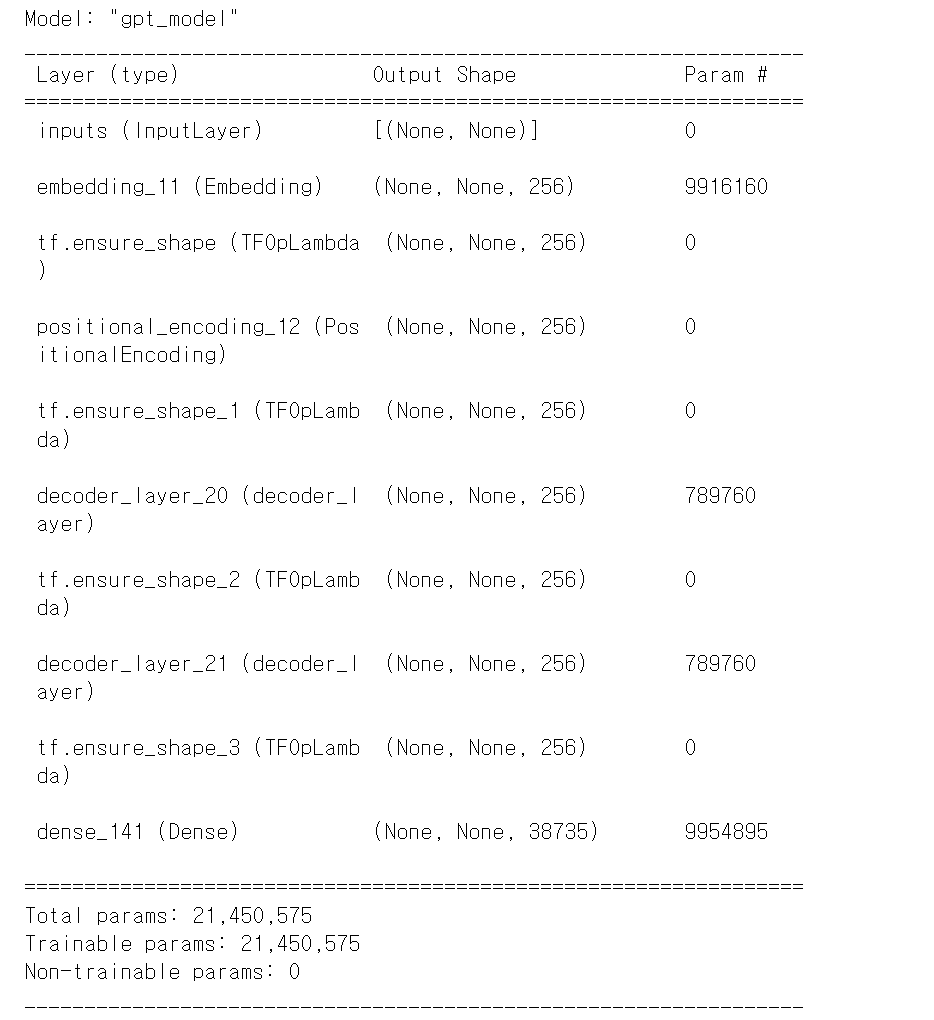
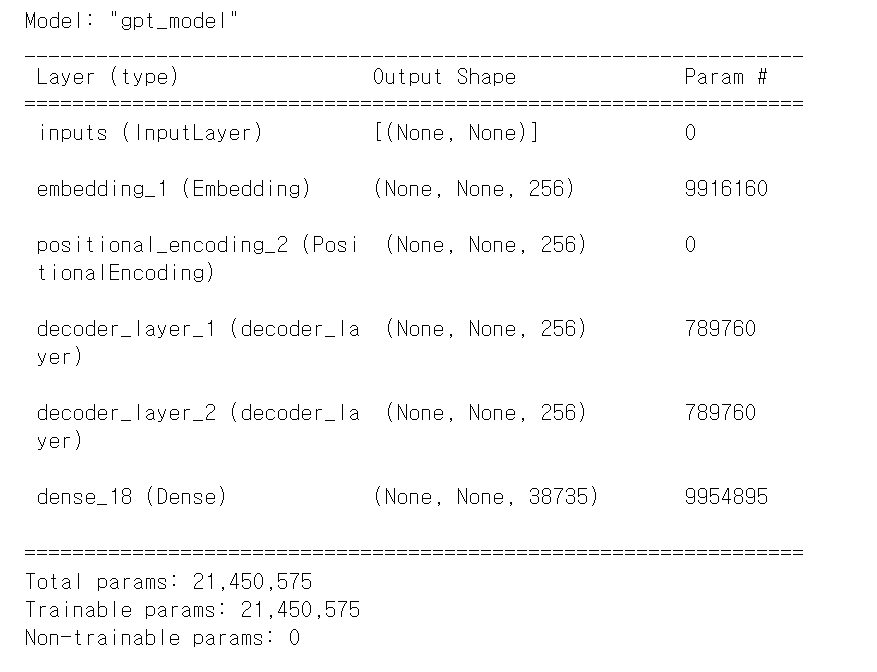


In [49]:
sample = next(iter(pretrain_dataset))
print("입력 shape:", sample[0].shape)  # (batch_size, seq_length)
print("타겟 shape:", sample[1].shape)  # (batch_size, seq_length)


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Index out of range using input dim 0; input has only 0 dims
	 [[{{node strided_slice_1}}]] [Op:IteratorGetNext]

In [46]:
# 사전학습 데이터셋 생성
pretrain_dataset = create_lm_dataset(
    pretrain_tokenizer, pretrain_files, seq_length=128, batch_size=8
)

# 사전학습 모델 생성 및 학습
pretrain_model = build_gpt_model(PRETRAIN_VOCAB_SIZE)
pretrain_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
pretrain_model.fit(pretrain_dataset, epochs=100)


Epoch 1/100


ValueError: in user code:

    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'tf.ensure_shape_3' (type TFOpLambda).
    
    Shape must be rank 3 but is rank 4 for '{{node gpt_model/tf.ensure_shape_3/EnsureShape}} = EnsureShape[T=DT_FLOAT, shape=[?,?,256]](gpt_model/embedding_1/embedding_lookup/Identity_1)' with input shapes: [?,128,?,256].
    
    Call arguments received by layer 'tf.ensure_shape_3' (type TFOpLambda):
      • x=tf.Tensor(shape=(None, 128, None, 256), dtype=float32)
      • shape=['None', 'None', '256']
      • name=None


In [67]:
# 데이터셋 샘플 형태 확인
sample = next(iter(pretrain_dataset))
print("입력 형태:", sample[0].shape)  # (batch_size, seq_length)
print("타겟 형태:", sample[1].shape)  # (batch_size, seq_length)

# 모델 출력 형태 확인
test_output = pretrain_model.predict(sample[0])
print("모델 출력 형태:", test_output.shape)  # (batch_size, seq_length, vocab_size)


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shape of tensor args_0 [] is not compatible with expected shape [11].
	 [[{{node EnsureShape}}]] [Op:IteratorGetNext]

사전학습,미세조정 검증

In [68]:
def validate_pretrain(model, dataset, steps=100):
    total_loss = 0
    for step, (inputs, targets) in enumerate(dataset.take(steps)):
        loss = model.test_on_batch(inputs, targets)
        total_loss += loss
    return total_loss / steps

# 미세조정 검증
def validate_finetune(model, dataset):
    return model.evaluate(dataset, verbose=0)

가중치 전이 추가(챗봇 모델에 사전학습 가중치 로드)

In [69]:
chatbot_model = build_gpt_model(VOCAB_SIZE)
for i in range(min(len(chatbot_model.layers), len(pretrain_model.layers))):
    chatbot_model.layers[i].set_weights(pretrain_model.layers[i].get_weights())

ValueError: Layer embedding_2 weight shape (8144, 256) is not compatible with provided weight shape (38735, 256).

In [70]:
import numpy as np
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수 2에서 12로 변경
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원 256에서 768로 변경
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 8에서 12로 변경 
DROPOUT = 0.1 # 드롭아웃의 비율 0.1에서 

chatbot_model = build_gpt_model(VOCAB_SIZE)

chatbot_model.summary()

Model: "gpt_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         2084864   
                                                                 
 tf.ensure_shape (TFOpLambda  (None, None, 256)        0         
 )                                                               
                                                                 
 positional_encoding (Positi  (None, None, 256)        0         
 onalEncoding)                                                   
                                                                 
 decoder_layer (decoder_laye  (None, None, 256)        789760    
 r)                                                              
                                                         

모델
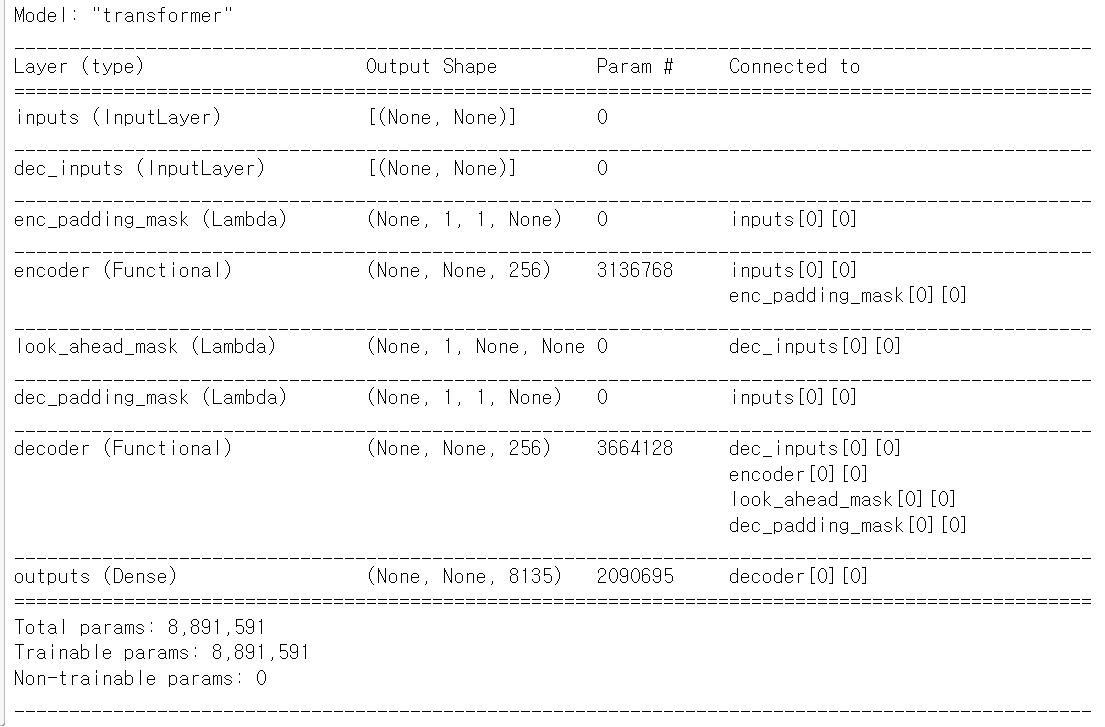

기존 loss_function 수정

In [71]:
def combined_loss(y_true, y_pred, alpha=0.5):
    # 지도 학습 손실
    supervised_loss = loss_function(y_true, y_pred)
    
    # 언어모델링 손실 (마지막 토큰 제외)
    lm_target = y_true[:, 1:]
    lm_pred = y_pred[:, :-1, :]
    lm_loss = loss_function(lm_target, lm_pred)
    
    return supervised_loss + alpha * lm_loss
print("슝=3")

슝=3


In [73]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, max_lr, warmup_steps, total_steps):
        super().__init__()
        self.max_lr = max_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps

    def __call__(self, step):
        warmup_lr = self.max_lr * (step / self.warmup_steps)
        decay_step = tf.maximum(step - self.warmup_steps, 0)
        cosine_decay = 0.5 * (1 + tf.cos(np.pi * decay_step / (self.total_steps - self.warmup_steps)))
        return tf.minimum(warmup_lr, self.max_lr * cosine_decay)
print("슝=3")

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 9)

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

시각화자료
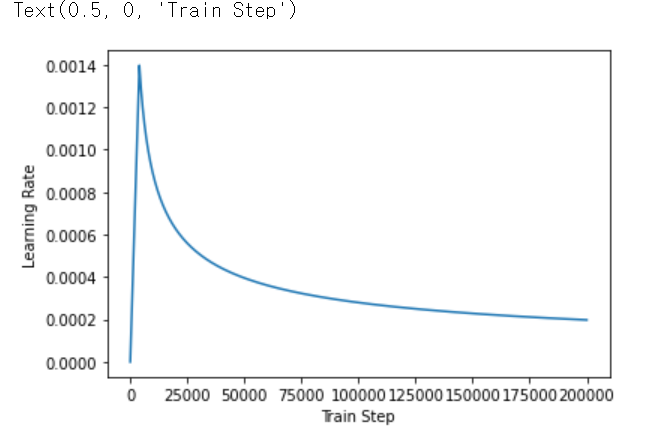

컴파일 수정(optimizer,loss부분)

In [74]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9, clipnorm=1.0)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(
    optimizer=optimizer,
    loss=lambda y_t, y_p: combined_loss(y_t, y_p, alpha=0.5),
    metrics=[accuracy]
)
print("슝=3")

NameError: name 'CustomSchedule' is not defined

In [ ]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

훈련
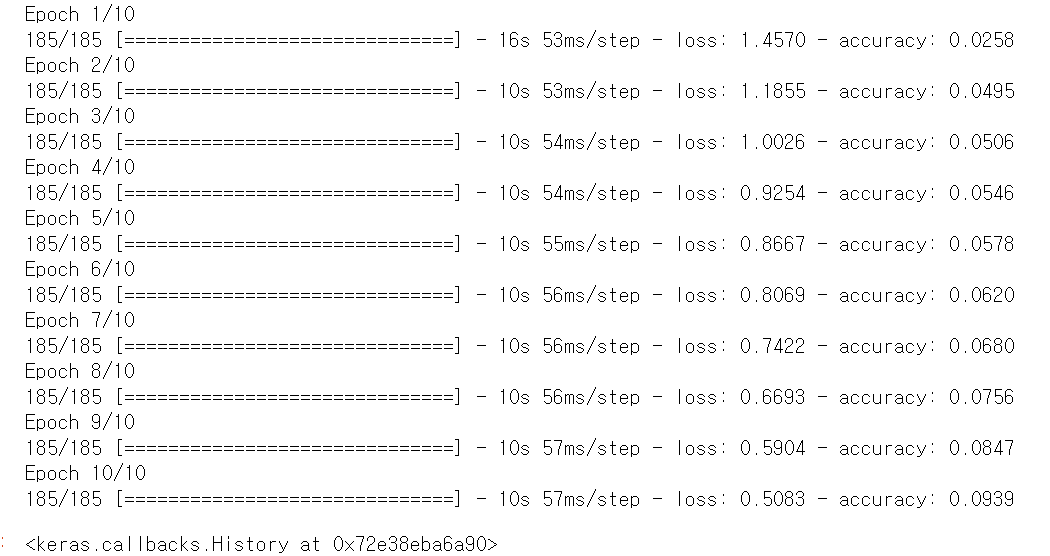
결과값은 그렇게 좋아보이지는 않는다

In [75]:
def gpt_inference(prompt, top_k=5, temperature=0.7):
    input_ids = tokenizer.encode(f"[CONTEXT]{prompt}")[:MAX_LENGTH-2]
    input_ids = [START_TOKEN[0]] + input_ids + [END_TOKEN[0]]
    input_ids = tf.expand_dims(input_ids, 0)
    
    for i in range(MAX_LENGTH):
        predictions = model(inputs=input_ids, training=False)
        next_token_logits = predictions[:, -1, :]
        next_tokens = tf.random.categorical(next_token_logits/temperature, top_k)
        next_token = next_tokens[0,0].numpy()
        
        if next_token == END_TOKEN[0]: break
        input_ids = tf.concat([input_ids, [[next_token]]], axis=-1)
    
    return tokenizer.decode(input_ids[0].numpy().tolist())

print("슝=3")

슝=3


In [78]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = gpt_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [79]:
print(sentence_generation('나 오늘 기분이 안좋아'))
# 출력 예: 기분이 안 좋을 땐 조용한 음악을 들어보세요 .


NameError: name 'model' is not defined

In [ ]:
sentence_generation('나 오늘 기분이 안좋아')
sentence_generation('시험을 잘봐서 너무 좋아')

이상한 말을 한다
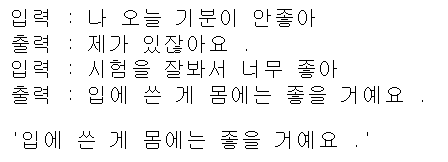


In [ ]:
sentence_generation('기분 않좋을떄는 어떻게 해야 할까?')

In [ ]:
sentence_generation('오늘 날씨 좋다')

In [ ]:
sentence_generation('그만')

In [ ]:
sentence_generation('멈춰')

In [ ]:
sentence_generation('오늘 힘들어')

In [ ]:
sentence_generation('짜증나')

lms상에서 진행한 코드를 거의 동일하게 사용했는데 결과값이 좋지 않아 조금 더 좋게 나올수 있게 수정을 해야할 것 같다.

변경 학습을 20번으로 수정,맥락파악 함수를 추가,디코더 부분을 top-k방식 사용

논문에 맞게 미세조정을 하고 디코더와 인코더를 삭제하고 디코더로 작동하게 하고,사전학습을 통해 효율을 높이는 방식을 진행하였는데,
영어를 못해서 인지 모델을 못만들어서 인지 어려움이 많았다.지금까지는 메모리를 신경쓸 필요가 없었는데 논문의 방식대로 크기를 키우고 진행하니 메모리 부족현상이 일어나 자꾸 커널이 죽었다.이 부분을 원활하게 해결하지 못해 모델학습과 점검을 하지 못하였다.